In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time
import gcmpyo3

from core.amp.likelihood import probit_likelihood
from core.amp.prior.nonseparable_gaussian_prior import NonSepGaussianPrior
import core.erm.logistic_regression as logistic_regression
from core.utility import KERNEL_COEFICIENTS, get_additional_noise_from_kappas, LOGISTIC_APPROX_COEF, sigmoid, build_gcm_from_activation

import simulations
import search_lambda

%load_ext autoreload
%autoreload 2

In [2]:
d         = 200
seeds     = 1

n_over_d  = 10.0
noise_std = 0.0
noise_var = noise_std**2

activation= 'erf'
_, kappa1, kappastar = KERNEL_COEFICIENTS[activation]

In [3]:
inv_alpha_range = np.array([0.1, 0.14949494949494951, 0.198989898989899, 0.24848484848484848, 0.297979797979798, 0.3474747474747475, 0.396969696969697, 0.44646464646464656, 0.495959595959596, 0.5454545454545455, 0.5949494949494949, 0.6444444444444445, 0.693939393939394, 0.7434343434343434, 0.7929292929292932, 0.8424242424242424, 0.891919191919192, 0.9414141414141416, 0.990909090909091, 1.0404040404040404, 1.0898989898989901, 1.1393939393939396, 1.188888888888889, 1.2383838383838386, 1.287878787878788, 1.3373737373737375, 1.386868686868687, 1.4363636363636367, 1.4858585858585862, 1.5353535353535357, 1.5848484848484852, 1.6343434343434347, 1.6838383838383841, 1.7333333333333334, 1.782828282828283, 1.8323232323232326, 1.881818181818182, 1.9313131313131315, 1.9808080808080812, 2.0303030303030307, 2.0797979797979806, 2.1292929292929297, 2.178787878787879, 2.2282828282828286, 2.277777777777778, 2.327272727272728, 2.376767676767677, 2.4262626262626266, 2.4757575757575765, 2.525252525252526, 2.5747474747474755, 2.624242424242425, 2.6737373737373744, 2.7232323232323234, 2.772727272727274, 2.8222222222222233, 2.8717171717171723, 2.921212121212122, 2.9707070707070717, 3.020202020202021, 3.06969696969697, 3.11919191919192, 3.168686868686869, 3.2181818181818187, 3.267676767676768, 3.3171717171717177, 3.366666666666668, 3.416161616161617, 3.465656565656567, 3.5151515151515156, 3.564646464646465, 3.6141414141414154, 3.663636363636365, 3.713131313131313, 3.7626262626262625, 3.812121212121213, 3.8616161616161624, 3.911111111111112, 3.9606060606060622, 4.010101010101011, 4.05959595959596, 4.10909090909091, 4.158585858585859, 4.208080808080809, 4.257575757575759, 4.307070707070707, 4.356565656565657, 4.406060606060607, 4.455555555555557, 4.505050505050505, 4.5545454545454565, 4.604040404040404, 4.653535353535354, 4.703030303030304, 4.752525252525253, 4.802020202020202, 4.851515151515152, 4.901010101010103, 4.950505050505051, 5.0])

index = [ i for i in range(0, len(inv_alpha_range), 5) if 4.5 >= inv_alpha_range[i] >= 0.5 ]

inv_alpha_range = inv_alpha_range[index]
erm_lambda_error = [ search_lambda.erm_compute_optimal_lambda_for_error(1.0 / inv_alpha, noise_std, n_over_d * inv_alpha, activation, 1e-3, 10.0, 1e-4, False, 1.0) for inv_alpha in inv_alpha_range ]
n_alpha = len(inv_alpha_range)

In [4]:
max_p        = int(n_over_d * d * inv_alpha_range[-1])
F_global     = np.random.normal(0.0, 1.0, size=(max_p, d)) / np.sqrt(d)

In [5]:
hessian_array, q_array, m_array = np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha)), np.zeros((seeds, n_alpha))
for s in range(seeds):
    try:
        m_list, q_list, hessian_list = simulations.erm_trial(d, n_over_d, inv_alpha_range, erm_lambda_error, kappa1, kappastar, noise_std, F_global)
        q_array[s] = q_list
        m_array[s] = m_list
        hessian_array[s] = hessian_list
    except Exception as e:
        print(e)
        q_array[s] = q_array[s-1]
        m_array[s] = m_array[s-1]
        hessian_array[s] = hessian_array[s-1]

16it [01:43,  6.48s/it]


In [6]:
m_list = np.mean(m_array, axis=0)
q_list = np.mean(q_array, axis=0)
hessian_list = np.mean(hessian_array, axis=0)

In [7]:
qs_for_erm_error = []
ms_for_erm_error = []


for inv_alpha, lambda_ in tqdm(zip(inv_alpha_range, erm_lambda_error)):
    alpha = 1. / inv_alpha
    gamma = n_over_d / alpha
    
    m, q, v, mhat, qhat, vhat = gcmpyo3.state_evolution.erm_state_evolution_gcm(alpha, noise_var, gamma, kappa1, kappastar, lambda_, 1.0, "logit", 1e-6, False)
    qs_for_erm_error.append(q)
    ms_for_erm_error.append(m)

16it [00:00, 19.16it/s]


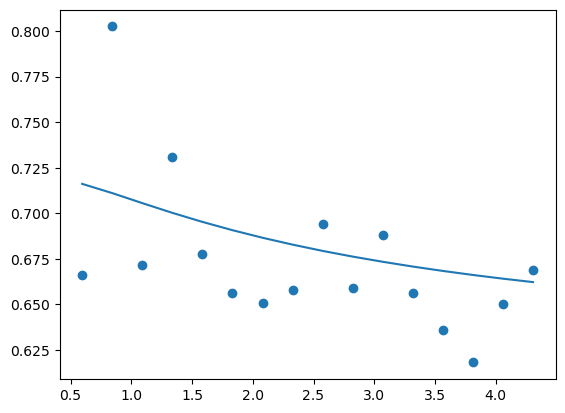

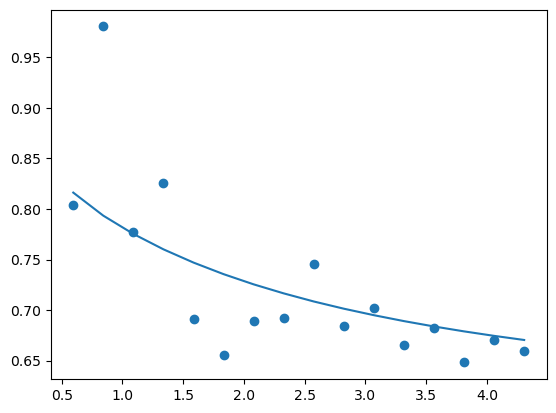

In [8]:
plt.scatter(inv_alpha_range, m_list)
plt.plot(inv_alpha_range, np.array(ms_for_erm_error))
plt.show()

plt.scatter(inv_alpha_range, q_list)
plt.plot(inv_alpha_range, np.array(qs_for_erm_error))
plt.show()

In [9]:
print('Experimental values of m : ')
print(list(m_list))
print('Experimental values of q : ')
print(list(q_list))
print('Experimental values of Hessian trace : ')
print(list(hessian_list))

Experimental values of m : 
[0.6658973121963578, 0.8024989007733516, 0.6715931277048163, 0.7310876868009556, 0.6776465301638329, 0.6562201062294563, 0.6505858263271729, 0.6581024782941384, 0.6939923045347387, 0.658700331559985, 0.6881602469266186, 0.6561238954479015, 0.6358623640262507, 0.6180910298032054, 0.6500967560813509, 0.6689675924446499]
Experimental values of q : 
[0.8036686233655629, 0.9804474446350476, 0.7773160452394188, 0.8261237526958483, 0.6908955174151054, 0.6557294665760837, 0.6891859182983465, 0.69223353797758, 0.7452827576681563, 0.6847061253479382, 0.7021137390445322, 0.6650947242376548, 0.6822925476959333, 0.6482119017910624, 0.6704396098148188, 0.659463818691944]
Experimental values of Hessian trace : 
[0.5264426685461641, 0.5292867321178347, 0.5115809232232487, 0.5094916950172395, 0.49838029261050365, 0.4930655256305333, 0.490693213273264, 0.4869084450615878, 0.48562792973528335, 0.47795656361481864, 0.4766435361993774, 0.4739145050952277, 0.46919921979319656, 0.